# Model Preparation & Training

## 0. Setup

In [1]:
# import related libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

#import package for features engineering & transformation
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

# import related classification model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# import rleated evaluation metric
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

/Users/faizpuad/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Preparation

In [2]:
# specify cleaned file location
clean_file = '../data/processed/loan_default_data.csv'

# read source file as dataframe
df = pd.read_csv(clean_file)

# expand the display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Split into features and label
y = df['repay_fail']
X = df.drop(['repay_fail'], axis=1)

In [4]:
# Normalize the data
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [5]:
X.describe()

,last_payment_amnt,total_received_principal,term_ordinal,total_payment_investors,total_payment,term_since_last_pay_mth,purpose_small_business,inquiries_last_6mths,interest_rate,purpose_credit_card,funded_amount,installment,loan_amount,funded_amount_investors,interest_rate.1,revolving_utillization,purpose_small_business.1,debt_to_income_ratio,verification_status_Verified,purpose_major_purchase
count,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000
mean,0.264026,0.364153,0.240298,0.353084,0.361386,0.424125,0.046723,0.208129,0.499030,0.130392,0.358671,0.389751,0.369904,0.360753,0.499030,0.412924,0.046723,0.445367,0.552954,0.054282
std,0.340537,0.253767,0.427270,0.259636,0.252152,0.211801,0.211048,0.257877,0.182365,0.336739,0.229298,0.241909,0.238058,0.243141,0.182365,0.238258,0.211048,0.224073,0.497195,0.226576
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.026794,0.171216,0.000000,0.156273,0.170396,0.263566,0.000000,0.000000,0.375000,0.000000,0.171908,0.202829,0.179357,0.179510,0.375000,0.216807,0.000000,0.273091,0.000000,0.000000
50%,0.068699,0.307597,0.000000,0.289244,0.299344,0.465116,0.000000,0.200000,0.492793,0.000000,0.318658,0.338770,0.324873,0.304624,0.492793,0.416807,0.000000,0.448816,1.000000,0.000000
75%,0.416076,0.502729,0.000000,0.493764,0.502237,0.558140,0.000000,0.400000,0.625000,0.000000,0.503145,0.521697,0.507614,0.507706,0.625000,0.610924,0.000000,0.621874,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2024, stratify=y)

# Print the shape size of train dataset
print(X_train.shape, y_train.shape)

# Print the shape size of test dataset
print(X_test.shape, y_test.shape)

(25559, 20) (25559,)
(10954, 20) (10954,)


### Oversampling

In [7]:
# Concatenate our training data back together
train_data = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
majority_class = train_data[train_data.repay_fail == 0]
minority_class = train_data[train_data.repay_fail == 1]

# Upsample minority class
minority_upsampled = resample(minority_class, 
                              replace=True,     # sample with replacement
                              n_samples=len(majority_class),    # to match majority class
                              random_state=2024)

# Combine majority class with upsampled minority class
upsampled_train = pd.concat([majority_class, minority_upsampled])

# Separate X and y for the upsampled train set
X_train_resampled = upsampled_train.drop(columns=['repay_fail'])
y_train_resampled = upsampled_train['repay_fail']

### Model Training

### Create model pipeline

In [8]:
random.seed(2024)
np.random.seed(2024)

# Define models and parameter grids
models = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

param_grids = {
    'SVM': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']},
    'Logistic Regression': {'classifier__C': [0.1, 1, 10], 'classifier__solver': ['liblinear']},
    'Naive Bayes': {},
    'Random Forest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 10, 20]},
    'Decision Tree': {'classifier__max_depth': [None, 10, 20], 'classifier__min_samples_split': [2, 5, 10]}
}

# Define scoring metrics
scoring = {
    'F1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score)
}

# Initialize lists to store results
best_params = {}
best_scores = {}

# Perform GridSearchCV for each model
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[model_name], scoring='f1', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Store best parameters and scores
    best_params[model_name] = grid_search.best_params_
    best_scores[model_name] = grid_search.best_score_
    
    # Print results
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1 Score for {model_name}: {grid_search.best_score_}")

Tuning SVM...


/Users/faizpuad/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/faizpuad/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/faizpuad/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/faizpuad/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/faizpuad/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning:

Best Parameters for SVM: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best F1 Score for SVM: 0.993936116553128
Tuning Logistic Regression...


/Users/faizpuad/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/faizpuad/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Best Parameters for Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Best F1 Score for Logistic Regression: 0.9875723813682079
Tuning Naive Bayes...
Best Parameters for Naive Bayes: {}
Best F1 Score for Naive Bayes: 0.8282416969293674
Tuning Random Forest...
Best Parameters for Random Forest: {'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Best F1 Score for Random Forest: 0.9996541520866229
Tuning Decision Tree...
Best Parameters for Decision Tree: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2}
Best F1 Score for Decision Tree: 0.9967598734037268


In [9]:
# Tabulate best parameters and scores
results_df = pd.DataFrame.from_dict(best_params, orient='index')
results_df['Best F1 Score'] = results_df.index.map(best_scores)
results_df.reset_index(inplace=True)
print("\nBest Parameters and Scores for Each Model:\n", results_df)


Best Parameters and Scores for Each Model:
                  index  classifier__C classifier__kernel classifier__solver  \
0                  SVM           10.0                rbf                NaN   
1  Logistic Regression           10.0                NaN          liblinear   
2        Random Forest            NaN                NaN                NaN   
3        Decision Tree            NaN                NaN                NaN   

   classifier__max_depth  classifier__n_estimators  \
0                    NaN                       NaN   
1                    NaN                       NaN   
2                   20.0                     100.0   
3                   20.0                       NaN   

   classifier__min_samples_split  Best F1 Score  
0                            NaN       0.993936  
1                            NaN       0.987572  
2                            NaN       0.999654  
3                            2.0       0.996760  



Evaluating SVM...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9296
           1       1.00      0.97      0.98      1658

    accuracy                           1.00     10954
   macro avg       1.00      0.99      0.99     10954
weighted avg       1.00      1.00      1.00     10954



<Figure size 1000x600 with 0 Axes>

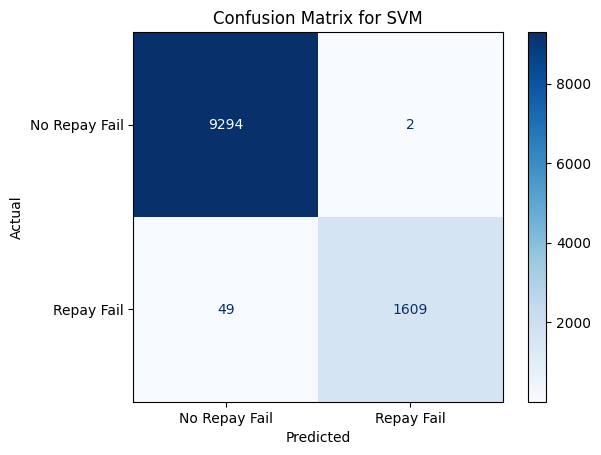


Evaluating Logistic Regression...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9296
           1       0.98      0.98      0.98      1658

    accuracy                           0.99     10954
   macro avg       0.99      0.99      0.99     10954
weighted avg       0.99      0.99      0.99     10954



<Figure size 1000x600 with 0 Axes>

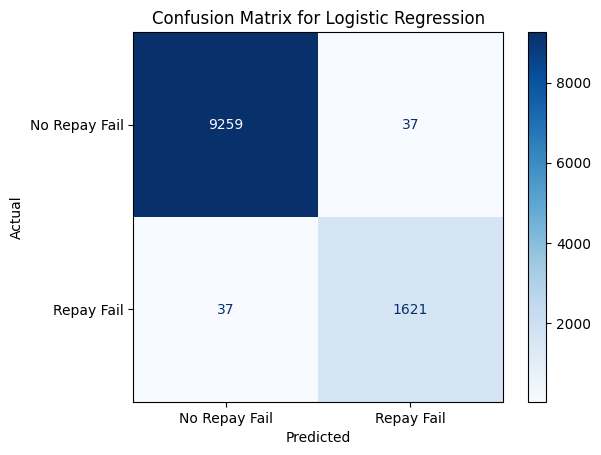


Evaluating Naive Bayes...
              precision    recall  f1-score   support

           0       0.97      0.76      0.86      9296
           1       0.40      0.88      0.55      1658

    accuracy                           0.78     10954
   macro avg       0.69      0.82      0.70     10954
weighted avg       0.89      0.78      0.81     10954



<Figure size 1000x600 with 0 Axes>

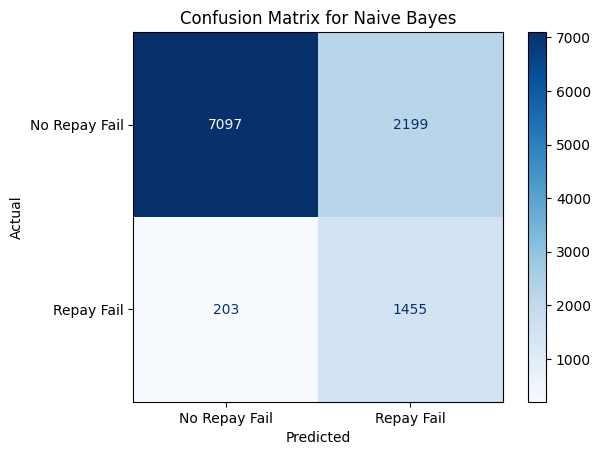


Evaluating Random Forest...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9296
           1       1.00      0.96      0.98      1658

    accuracy                           0.99     10954
   macro avg       1.00      0.98      0.99     10954
weighted avg       0.99      0.99      0.99     10954



<Figure size 1000x600 with 0 Axes>

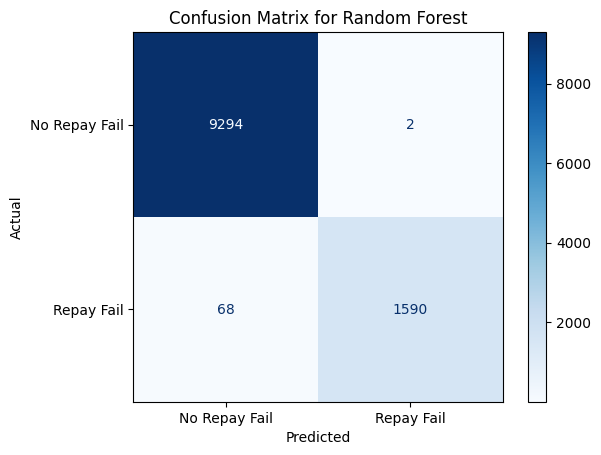


Evaluating Decision Tree...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9296
           1       0.96      0.96      0.96      1658

    accuracy                           0.99     10954
   macro avg       0.98      0.98      0.98     10954
weighted avg       0.99      0.99      0.99     10954



<Figure size 1000x600 with 0 Axes>

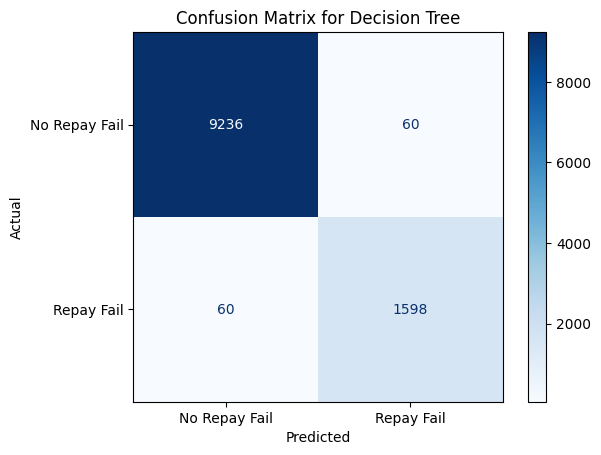

In [10]:
# Evaluate the best models on the test set
final_results = []
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    pipeline.set_params(**best_params[model_name])
    pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Predictions and evaluation
    y_test_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    
    final_results.append({
        'Model': model_name,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    })
    
    # Print classification report
    print(classification_report(y_test, y_test_pred))
    
    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 6))
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Repay Fail', 'Repay Fail'], yticklabels=['No Repay Fail', 'Repay Fail'])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Repay Fail', 'Repay Fail'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [11]:
# Tabulate final results
final_results_df = pd.DataFrame(final_results)
print("\nFinal Evaluation Metrics for Each Model:\n", final_results_df)


Final Evaluation Metrics for Each Model:
                  Model  F1 Score  Precision    Recall
0                  SVM  0.984399   0.998759  0.970446
1  Logistic Regression  0.977684   0.977684  0.977684
2          Naive Bayes  0.547816   0.398194  0.877563
3        Random Forest  0.978462   0.998744  0.958987
4        Decision Tree  0.963812   0.963812  0.963812


Based on the metrics evaluation done for each classification model:
- SVM, Logistic Regression, Random Forest and Decision tree fairly have similar high F1 score on training data
- To select the best model, the assumption made are:
    - Model must able to clearly detect True Positive (Repay fail) as it is the main concern on business risk exposure
    - Model also must generalize enough (not too perfectly or too poorly perform in both train and test)
- Thus, logistic regression is selected as the most suitable as it has high training F1_score, and susbequent almost uniform prediction score for test data and fairly not too overfit (near 100%)